##Background
#### Audio Classification From Image Level
The audio classification is a traditional and challenging field, it is the process of analyzing and categorizing audio signals into predefined categories or labels using deep learning techniques. In essence, audio classification systems are designed to recognize patterns within audio data. These systems typically convert raw audio signals into numerical representations using methods such as spectrograms, mel-frequency cepstral coefficients (MFCCs), or other feature extraction techniques. Once transformed, deep learning algorithms—often deep neural networks—analyze these features to identify and classify the sound into categories.

- https://www.mathworks.com/help/audio/ug/speaker-identification-using-pitch-and-mfcc.html


- https://librosa.org/doc/main/generated/librosa.feature.mfcc.html


- https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

## 1. Package

Let's first import all the packages.

- **torch, torch.nn, torch.nn.functional** are the fundamental modules in pytorch library.
- **torchvision** is a library for Computer Vision that goes hand in hand with PyTorch
- **numpy** is the fundamental package for scientific computing with Python programs.
- **matplotlib** is a library to plot graphs and images in Python.
- **math, random** are the standard modules in Python.

In [2]:
import math
import torch
import random
import librosa
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import IPython.display as ipd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from utils import *
from scipy.signal import resample

print("Import packages successfully!")

Import packages successfully!


A helper function for reproducibility:

```python
def set_seed(seed):
    """
    Use random seed to ensure that results are reproducible.
    """
```

In [4]:
seed = 1
set_seed(seed)

## Dataset

We use two types of audio: "**street music** vs. **children playing**".

Let's load the dataset first using pytorch dataset and loader modules.

In [8]:
# the number of audios feature in a batch
batch_size = 8

# load dataset
trainset = dataset(path='data/voice_train_UG.h5')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = dataset(path='data/voice_test_UG.h5')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True)

# name of classes
classes = ('street_music', 'children_playing')

print ("Number of training examples: " + str(trainset.length))

print ("Number of testing examples: " + str(testset.length))

Number of training examples: 1681
Number of testing examples: 288


**Visualization Features**
- Let's visualize some examples from the dataset using spectrogram maps:

The visualization features of street_music are:


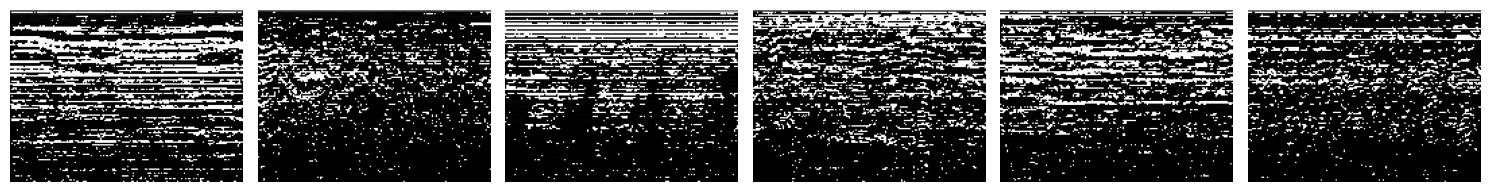

The visualization features of children_playing are:


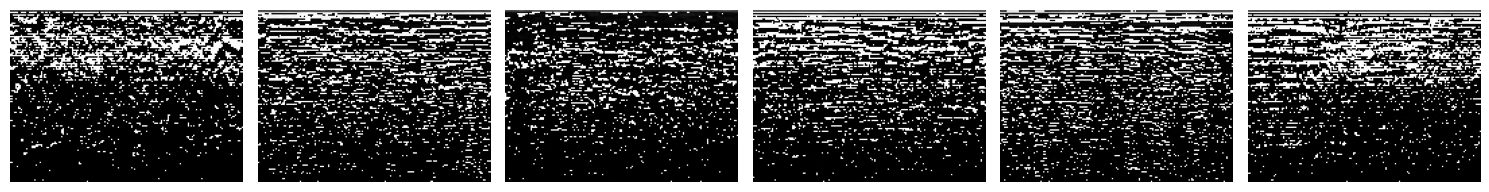

In [19]:
IMG_NUM_ROW = 6
feature_0 = []
feature_1 = []
STOP = False
while not STOP:
    dataiter = iter(trainloader)
    audios, labels = next(dataiter)
    for i in range(audios.shape[0]):
        label = labels[i:i+1]
        _, indexs = torch.max(label, 1) 
        if classes[indexs] == "street_music" and len(feature_0) <= IMG_NUM_ROW:
            img = torchvision.utils.make_grid(audios[i:i+1]*255)
            img = img / 2 + 0.5
            npimg = img.numpy().astype(np.uint8)
            feature_0.append(np.transpose(npimg, (1, 2, 0)))
        if classes[indexs] == "children_playing" and len(feature_1) <= IMG_NUM_ROW:
            img = torchvision.utils.make_grid(audios[i:i+1]*255)
            img = img / 2 + 0.5
            npimg = img.numpy().astype(np.uint8)
            feature_1.append(np.transpose(npimg, (1, 2, 0)))
        if len(feature_0) >= IMG_NUM_ROW and len(feature_1) >= IMG_NUM_ROW:
            STOP = True
            break

print("The visualization features of \033[91mstreet_music\033[0m are:")
fig, axes = plt.subplots(1, IMG_NUM_ROW, figsize=(15, 3))
for i in range(IMG_NUM_ROW):
    axes[i].imshow(feature_0[i])
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("The visualization features of \033[91mchildren_playing\033[0m are:")
fig, axes = plt.subplots(1, IMG_NUM_ROW, figsize=(15, 3))
for i in range(IMG_NUM_ROW):
    axes[i].imshow(feature_1[i])
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

**Listen the audios**
- Let's listen some examples:



```python
def ipd.Audio(audio_path):
"""
    Display the audios
    """
```

In [11]:
# display audio
children_playing = 'data/assets/children_playing_demo.wav'
print('The audio for children playing are: ')
ipd.Audio(children_playing)


The audio for children playing are: 


In [12]:
# display audio
street_music = 'data/assets/street_music_demo.wav'
print('The audio for street music are: ')
ipd.Audio(street_music)

The audio for street music are: 


# Method I

---
## Build feedforward neural network.

**Four-layer multilayer perceptron (MLP)** to classify images into different categories. 


The size of input spectrum is a batch-like tensor $ X \in \mathbb{R}^{B \times C \times H \times W} (C=1)$, where $B$ denotes the batch size. Vectorize the spectrum equals to transforming into a vector $X_{vector} \in \mathbb{R}^{B \times CHW}$.


In [22]:
def audio_vectorization(audio_batch):
    
    """
    Input: 
        audio_batch: a batch of audio/spectrum with shape [b, 1, h, w]
    Output: 
        vectorized_audio_batch: a batch of neurons
    """
    
     # vectorize the spectrum
    b, h, w= audio_batch.shape
    vectorized_audio_batch = audio_batch.reshape(b, 1 * h * w)
    return vectorized_audio_batch
    

**Each layer** of a MLP can be denoted as the following mathematical operation:

$$z = W^T x + b$$ 

Here, $W, b$ denote the weights and biases. The function is **parameterized by $W, b$**.

** Given the desired input, output dimensions, we generate the parameters $W, b$:

In [23]:
def get_layer_params(input_dim: int, output_dim: int):
    """
    Input: 
        input_dim: number of neurons in the input
        output_dim: number of neurons produced by the layer
    Output: 
        a dictionary of generated parameters
            - w: weights
            - b: biases
    """
    
    # generate the parameters
    # init weights 
    w = torch.randn(output_dim, input_dim, requires_grad=True) 
    
    
    # biases as zero
    b = torch.zeros(output_dim, requires_grad=True)
    
    return {'w': w,
            'b': b}


Following with the previous linear layer, an activation layer is required to add non-linearity to the network:


In [24]:
def activation_wrapper(z, activation='relu'):
    """
    Input: 
        x: the input neuron values
        activation: name of activation, could be one in ['relu', 'sigmoid', 'tanh']
    Output: 
        a: the corresponding activated output
    """
    
    if activation == 'relu':
        a = torch.max(torch.zeros_like(z), z)
    elif activation == 'sigmoid':
        a = 1 / (1 + torch.exp(-z))
    elif activation == 'tanh':
        a = (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))
        
    return a
    

** Given the layer parameters $W, b$ and the choice of $\sigma(\cdot)$, we compute the output for an MLP layer with input $x$. 


In [25]:
def layer_forward_computation(x, params, activation):
    """
    Input: 
        x: the input to the layer
        params: parameters of each layer
        activation: activation type
    Output: 
        a: the output after the activation
    """
    
    # compute the output for layer
    W = params['w']
    b = params['b']
    
    # matrix multiplication
    z = x.mm(W.t()) + b

    # Apply activition function
    a = activation_wrapper(z, activation)
    
    return a

---

Define layers for the a 4 layer MLP.

In [26]:
layer1_params: dict = dict()
layer2_params: dict = dict()
layer3_params: dict = dict()
layer4_params: dict = dict()
params: dict = dict()
activations: dict = dict()


def net(X, params, activations):
    """
    Input: 
        X: the input images to the network
        params: a dictionary of parameters(W and b) for the four different layers
        activations: a dictionary of activation function names for the four different layers
    Output: 
        output: the final output from the third layer
    """
    X_vector = audio_vectorization(X)
    layer1_out = layer_forward_computation(X_vector, params['layer1'], activations['layer1'])
    layer2_out = layer_forward_computation(layer1_out, params['layer2'], activations['layer2'])
    
    layer3_out = layer_forward_computation(layer2_out, params['layer3'], activations['layer3'])

    output = layer_forward_computation(layer3_out, params['layer4'], activations['layer4'])
    
    
    return output

- **Create parameters and activation functions.

In [27]:
# Define layer dimensions
N_1 = 128 * 173  # Input size
N_2 = 1024  # First hidden layer size
N_3 = 512   # Second hidden layer size
N_4 = 256   # Third hidden layer size
output_dim = 2  # Output size for 2-class classification

# Initialize layer parameters
layer1_params = get_layer_params(input_dim=N_1, output_dim=N_2)
layer2_params = get_layer_params(input_dim=N_2, output_dim=N_3)
layer3_params = get_layer_params(input_dim=N_3, output_dim=N_4)
layer4_params = get_layer_params(input_dim=N_4, output_dim=output_dim)

# Pack the parameters into a dictionary
params['layer1'] = layer1_params
params['layer2'] = layer2_params
params['layer3'] = layer3_params
params['layer4'] = layer4_params

# Define activations for each layer
activations['layer1'] = 'relu'
activations['layer2'] = 'relu'
activations['layer3'] = 'relu'
activations['layer4'] = 'sigmoid'  # Sigmoid for binary classification



## 4. Backpropagation and optimization

After finishing the forward pass, you now need to compute gradients for all Tensors with `requires_grad=True`, e.g., parameters of layer1. These gradients will be used to update parameters via gradient descent. 



** Update params function to update weights and biases based on the automatically calculated gradients.


In [29]:
def update_params(params, learning_rate):
    """
    Input: 
        params: the dictionary to store all the layer parameters
        learning_rate: the step length to update the parameters
    Output: 
        params: the updated parameters
    """
    
    with torch.no_grad():  # Ensure that parameter updates are not tracked
        for layer in params.keys():
            # Update weights in-place
            # print(f"params[layer]['w'].grad is {params[layer]['w'].grad}")
            if params[layer]['w'].grad is not None:
                params[layer]['w'].data.sub_(learning_rate * params[layer]['w'].grad)
            
            # Update biases in-place
            if params[layer]['b'].grad is not None:
                params[layer]['b'].data.sub_(learning_rate * params[layer]['b'].grad)

            # Clear gradients for both weights and biases
            if params[layer]['w'].grad is not None:
                params[layer]['w'].grad.zero_()
            
            if params[layer]['b'].grad is not None:
                params[layer]['b'].grad.zero_()

    return params


- Function to clear gradients after each weight update to no accumulate them.



In [14]:
def zero_grad(params):
    """
    Input: 
        params: the dictionary to store all the layer parameters
    Output: 
        params: the updated parameters with gradients clear
    """
    
    for layer in params.keys():
        if params[layer]['w'].grad is not None:
            params[layer]['w'].grad.zero_()

        if params[layer]['b'].grad is not None:
            params[layer]['b'].grad.zero_()
    
    
    return params
    

Combine compute gradients update weights/biases and clear gradients as the backpropagation function:


In [15]:
def backprop(loss, params, learning_rate):
    """
    Input: 
        loss: the loss tensor from the objective function that can be used to compute gradients
        params: parameters of the four layers
        learning_rate: the size of steps when updating parameters
    Output:
        params: parameters after one backpropagation
    """ 


    # Compute gradients
    loss.backward(retain_graph=True)

    # for layer in params.keys():
    #     print(f"Layer {layer} - Weight grad: {params[layer]['w'].grad}")
    #     print(f"Layer {layer} - Bias grad: {params[layer]['b'].grad}")

    # Update parameters based on gradients
    params = update_params(params, learning_rate)

    # Clear gradients
    params = zero_grad(params)

    
    return params
    

Function to initilize parameters:
```python
def init_params(params):
    """
    Initialize the parameters of each layer
    """
```

Learning decay so the closer to the optimal value we are the lower the learning rate.

In [16]:
def adjust_lr(learning_rate, epoch):
    """
    Input: 
        learning_rate: the input learning rate
        epoch: which epoch you are in
    Output:
        learning_rate: the updated learning rate
    """    

    if epoch % 15 ==0 and epoch >0:
        learning_rate = learning_rate * 0.1
    return learning_rate

Loss Function:

In [17]:
# define the initial learning rate here
learning_rate = 1e-2
n_epochs = 50 # how many epochs to run

# define loss function
criterion = nn.BCELoss()

# initialize network parameters
init_params(params)
    
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()
        inputs = inputs.float()

        # Forward 
        # print(inputs.shape)
        output = net(inputs, params, activations)
        # print(f"Network output: {output}")
        # print(f"Output shape: {output.shape}")
        
        # Compute the loss using the final output
        loss = criterion(output, labels)

        # Backpropagation
        params = backprop(loss, params, learning_rate)
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # print every 200 mini-batches
            print('[Epoch %03d, Step %05d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
    # adjust learning rate
    learning_rate = adjust_lr(learning_rate, epoch)
print('Finished Training')

[Epoch 001, Step 00010] loss: 0.694
[Epoch 001, Step 00020] loss: 0.693
[Epoch 001, Step 00030] loss: 0.694
[Epoch 001, Step 00040] loss: 0.693
[Epoch 001, Step 00050] loss: 0.693
[Epoch 001, Step 00060] loss: 0.693
[Epoch 001, Step 00070] loss: 0.693
[Epoch 001, Step 00080] loss: 0.693
[Epoch 001, Step 00090] loss: 0.692
[Epoch 001, Step 00100] loss: 0.691
[Epoch 001, Step 00110] loss: 0.692
[Epoch 001, Step 00120] loss: 0.692
[Epoch 001, Step 00130] loss: 0.692
[Epoch 001, Step 00140] loss: 0.692
[Epoch 001, Step 00150] loss: 0.693
[Epoch 001, Step 00160] loss: 0.692
[Epoch 001, Step 00170] loss: 0.689
[Epoch 001, Step 00180] loss: 0.691
[Epoch 001, Step 00190] loss: 0.692
[Epoch 001, Step 00200] loss: 0.691
[Epoch 001, Step 00210] loss: 0.692
[Epoch 002, Step 00010] loss: 0.692
[Epoch 002, Step 00020] loss: 0.689
[Epoch 002, Step 00030] loss: 0.692
[Epoch 002, Step 00040] loss: 0.691
[Epoch 002, Step 00050] loss: 0.691
[Epoch 002, Step 00060] loss: 0.690
[Epoch 002, Step 00070] loss

**Evaluation**: Test the trained model:

In [18]:
correct = 0
total = 0
# since you're not training, you don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        audios, labels = data
        _, labels = torch.max(labels, 1)
        
        # calculate outputs by running images through the network
        output = net(audios, params, activations)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the test images: 80 %


**Evaluation**: Test the trained model on different categories and calculate the accuracy of each category:

In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        _, labels = torch.max(labels, 1)
        output = net(images, params, activations)
        _, predictions = torch.max(output, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class street_music is: 79.3 %
Accuracy for class children_playing is: 81.8 %


# Method II

---

## 7. Using a convolutional neural network to classify the audios.


Vectorizing  has some drawbacks on the sharp signal or contextual information of audio/spectrum. The convolutional neural network is very good at capturing these patterns. 

** Two-layer CNN with a maxpooling layer in between.
**Architecture**:
1. CNN Layer1: we have a **3 or 5** as convolution kernel size; the number of output channels can be **[16, 32, 64]**; ReLU as activation function
2. CNN Layer2: we have a **3 or 5** as  convolution kernel size; the number of output channels can be **[128, 256]**;  ReLU as  activation function
3. FC layer: the input is projected from $\mathbb{R}^{B \times N}$ to $\mathbb{R}^{B \times 2}$; sigmoid function as activation function.
4. 

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1 in channel since we have spectrogram
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)

        # Max pool layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer
        self.fc = nn.Linear(157440, 2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        

    
        
    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1), x.size(2))
        # print(x.shape)
        # Pass through first Convolutional layer + pooling
        x = self.pool(self.relu(self.conv1(x)))
    
        # Pass through second Convolutional layer + pooling
        x = self.pool(self.relu(self.conv2(x)))
    
        # Flatten input for the fully connected layer
        x = x.view(x.size(0), -1)  # Dynamically flatten the tensor
    
        # Pass through the fully connected layer
        x = self.sigmoid(self.fc(x))
    
        return x


- To avoid overfitting, weight decay is usually introduced. And the weight decay helps in regularizing the model by penalizing large weights, which can improve generalization.

$$\large L = -\frac{\lambda}{2} ||w||^2$$

In [21]:
def weight_decay(cnn_model, l2_lambda, device):
    """
    Input: 
        cnn_model: the given cnn model
        l2_lambda: the hyperparameters for parameters, default is 1e-4
        device: the device when you run the model
    Output:
        _reg: the penalty value for the cnn_model
    """    

    _reg = 0  # init regularization term

    # Loop through model params
    for param in cnn_model.parameters():
        if param.requires_grad:  # only parameters with gradient should be included
            _reg += torch.norm(param).to(device) ** 2  # L2 norm squared for each parameter.

    # Summed norm times the regularization coefficient
    _reg = (l2_lambda / 2) * _reg
    
    return _reg

- Train model:

 

In [22]:
## The option for macbook
# device = torch.device("mps")
## The option for cuda
# device = torch.device("cuda")
## The option for cpu machine
device = torch.device("cpu")

# define the initial learning rate here
learning_rate = 1e-2
n_epochs = 50 # how many epochs to run
l2_lambda = 1e-4  # Weight decay regularization value
# define loss function
criterion = nn.BCELoss()


cnn_net = Net().to(device)
optimizer = torch.optim.SGD(cnn_net.parameters(), lr=learning_rate)

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.float().to(device)
        # print(inputs.shape)
        # inputs = inputs.view(inputs.size(0), 1, inputs.size(1), inputs.size(2))
        
        # Forward 
        output = cnn_net(inputs)
        
        # Compute the loss using the final output
        loss = criterion(output, labels) + weight_decay(cnn_net, l2_lambda, device)

        optimizer.zero_grad()
        
        # Backpropagation compute gradient
        loss.backward()

        # optimizer step to update model parameters
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[Epoch %d, Step %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Step    10] loss: 0.753
[Epoch 1, Step    20] loss: 0.709
[Epoch 1, Step    30] loss: 0.747
[Epoch 1, Step    40] loss: 0.685
[Epoch 1, Step    50] loss: 0.716
[Epoch 1, Step    60] loss: 0.685
[Epoch 1, Step    70] loss: 0.697
[Epoch 1, Step    80] loss: 0.682
[Epoch 1, Step    90] loss: 0.692
[Epoch 1, Step   100] loss: 0.680
[Epoch 1, Step   110] loss: 0.641
[Epoch 1, Step   120] loss: 0.688
[Epoch 1, Step   130] loss: 0.693
[Epoch 1, Step   140] loss: 0.656
[Epoch 1, Step   150] loss: 0.662
[Epoch 1, Step   160] loss: 0.653
[Epoch 1, Step   170] loss: 0.671
[Epoch 1, Step   180] loss: 0.634
[Epoch 1, Step   190] loss: 0.658
[Epoch 1, Step   200] loss: 0.670
[Epoch 1, Step   210] loss: 0.636
[Epoch 2, Step    10] loss: 0.674
[Epoch 2, Step    20] loss: 0.670
[Epoch 2, Step    30] loss: 0.639
[Epoch 2, Step    40] loss: 0.620
[Epoch 2, Step    50] loss: 0.581
[Epoch 2, Step    60] loss: 0.585
[Epoch 2, Step    70] loss: 0.609
[Epoch 2, Step    80] loss: 0.628
[Epoch 2, Step

In [23]:
correct = 0
total = 0
cnn_net.cpu()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        audios, labels = data

        _, labels = torch.max(labels, 1)
        
        # calculate outputs by running images through the network
        output = cnn_net(audios)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the test images: 89 %


In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data

        _, labels = torch.max(labels, 1)
        output = cnn_net(images)
        _, predictions = torch.max(output, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class street_music is: 94.5 %
Accuracy for class children_playing is: 85.3 %


# Method III

---

## 1. Building Multiple Classification System.

A 10-class problem (<font color=Green>"dog_bark", "children_playing", "air_conditioner", "street_music", "engine_idling", "car_horn", "siren", "jackhammer", "drilling", "gun_shot"</font>).



In [66]:
### Listen the Samples
# Set the sample we want to listen
sample_to_listen = "gun_shot" # "dog_bark"

classes = ("dog_bark", "children_playing", "air_conditioner", "street_music", "engine_idling", "car_horn", "siren", "jackhammer", "drilling", "gun_shot")
index_label = classes.index(sample_to_listen)
labels = list(np.load("data/Train_label.npy"))
index = labels.index(index_label)

print('The audio for %s are: '%sample_to_listen)
ipd.Audio("data/train/%07d.wav"%index)

The audio for gun_shot are: 


- Load dataset class:



```python
class dataset(torch.utils.data.Dataset):
    def __init__(self, path='./dataset/trainset.h5'):
        f = h5py.File(path, 'r')
        self.data = f['data']
        self.label = f['label']
        
        self.length = self.data.shape[0]
    
    def __getitem__(self, index):
        label = self.label[index]
        new_label = np.zeros(2)
        new_label[int(label)] = 1
        return self.data[index], new_label
    
    def __len__(self):
        return self.length
```

In [78]:
device = torch.device("mps")

In [79]:
from tqdm import trange

class dataset_audio(torch.utils.data.Dataset):
    def __init__(self, data_path='./data/', label_path='./label.npy', max_len=126):
        self.data_path = data_path
        self.labels = np.load(label_path)
        self.max_len = max_len

        # List audio files in the data path
        self.audio_files = sorted(os.listdir(self.data_path))

        # Ensure the dataset  length matches
        assert len(self.audio_files) == len(self.labels)


    def __len__(self):
        """
        Return dataset length.
        """
        return len(self.audio_files)

    def __getitem__(self, index):
        """
        Get audio file at specific index.
        """
        audio_file_path = os.path.join(self.data_path, self.audio_files[index])
        audio_data, sample_rate = librosa.load(audio_file_path, sr=16000)

        # Extract features from audio with librosa
        audio_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_fft=512)

        # Pad to ensure all features same length when extracted by librosa
        if audio_features.shape[1] < self.max_len:
            # Pad to max_len
            pad_width = self.max_len - audio_features.shape[1]
            # print(f"{self.max_len} - {audio_features.shape[1]} = {pad_width}")
            audio_features = np.pad(audio_features, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to max_len
            audio_features = audio_features[:, :self.max_len]

  # Get corresponding label and one-hot encode it
        label = int(self.labels[index])

        # Return audio features with one-hot encoded label
        return torch.tensor(audio_features, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.long).to(device)

            



In [82]:
batch_size = 32

# load dataset
trainset = dataset_audio(data_path='data/train/', label_path='data/Train_label.npy')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = dataset_audio(data_path='data/test/', label_path='data/Test_label.npy')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# name of classes
classes = ("dog_bark", "children_playing", "air_conditioner", "street_music", "engine_idling", "car_horn", "siren", "jackhammer", "drilling", "gun_shot")
print ("Number of training examples: %d"%len(trainset))
print ("Number of testing examples: %d"%len(testset))

Number of training examples: 8232
Number of testing examples: 1000


- Build CNN

In [94]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(9920, 256)
        self.fc2 = nn.Linear(256,10)

        self.relu = nn.ReLU()
    
        
    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1), x.size(2))
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits, no activation
        return x

In [84]:
def adjust_learning_rate(optimizer, epoch, initial_lr):
    """
    Adjusts the learning rate of the optimizer during training.
    
    Input: 
        optimizer: the optimizer being used
        epoch: the current epoch
        initial_lr: the initial learning rate
    """
    # Every 15 epochs, reduce the learning rate by a factor of 10
    if epoch % 15 == 0 and epoch > 0:
        new_lr = initial_lr * (0.1 ** (epoch // 15))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr


- Training loop

In [95]:
# define the initial learning rate here
initial_lr = 0.001
n_epochs =  50
l2_lambda = 1e-4  # Weight decay regularization value
# define loss function
criterion = nn.CrossEntropyLoss()
cnn_net = Net().to(device)
# we give the weight decay directly to the optimizer
optimizer =   torch.optim.SGD(cnn_net.parameters(), lr=initial_lr, weight_decay=l2_lambda) 

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs_3, labels_3 = data

        outputs = cnn_net(inputs_3)

        loss = criterion(outputs, labels_3)

        # Zero parameter gradients
        optimizer.zero_grad()
        
        # Compute gradients
        loss.backward()

        # Optimize wights
        optimizer.step()
        
        # 
        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[Epoch %03d, Step %05d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
    
    adjust_learning_rate(optimizer, epoch, initial_lr)
print('Finished Training')

[Epoch 001, Step 00010] loss: 22.415
[Epoch 001, Step 00020] loss: 2.177
[Epoch 001, Step 00030] loss: 2.077
[Epoch 001, Step 00040] loss: 1.950
[Epoch 001, Step 00050] loss: 1.877
[Epoch 001, Step 00060] loss: 1.733
[Epoch 001, Step 00070] loss: 1.646
[Epoch 001, Step 00080] loss: 1.692
[Epoch 001, Step 00090] loss: 1.670
[Epoch 001, Step 00100] loss: 1.643
[Epoch 001, Step 00110] loss: 1.596
[Epoch 001, Step 00120] loss: 1.636
[Epoch 001, Step 00130] loss: 1.642
[Epoch 001, Step 00140] loss: 1.597
[Epoch 001, Step 00150] loss: 1.483
[Epoch 001, Step 00160] loss: 1.574
[Epoch 001, Step 00170] loss: 1.545
[Epoch 001, Step 00180] loss: 1.461
[Epoch 001, Step 00190] loss: 1.478
[Epoch 001, Step 00200] loss: 1.460
[Epoch 001, Step 00210] loss: 1.366
[Epoch 001, Step 00220] loss: 1.475
[Epoch 001, Step 00230] loss: 1.477
[Epoch 001, Step 00240] loss: 1.467
[Epoch 001, Step 00250] loss: 1.379
[Epoch 002, Step 00010] loss: 1.353
[Epoch 002, Step 00020] loss: 1.304
[Epoch 002, Step 00030] los

KeyboardInterrupt: 

## Testing CNN

In [1]:
correct = 0
total = 0

cnn_net = cnn_net.cpu()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.float()
        _, labels = torch.max(labels, 1)
        # calculate outputs by running images through the network
        output = cnn_net(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

NameError: name 'cnn_net' is not defined

In [108]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.float()
        _, labels = torch.max(labels, 1)
        output = cnn_net(images)
        _, predictions = torch.max(output, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)